In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts.utils import data_path, set_mpl
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

%matplotlib widget

set_mpl()

matplotlib settings set
matplotlib settings set


## insturctions for donwloading twitter data

0. Install `snscrape` (https://github.com/JustAnotherArchivist/snscrape).

1. check if it works

`snscrape --progress --jsonl --max-results 10  twitter-search "geocode:51.5072,-0.1276,5km lang:en  since:2014-02-26 until:2014-02-27  -filter:replies" > twitter_test.json;`

it should create a file called `twitter_test.json' with 10 tweets


The following I would run in parallel (e.g. in separate terminal tabs) to make it faster:

* query for last 6 months periods in parallel:

`snscrape --progress --jsonl  twitter-search "geocode:51.5072,-0.1276,5km lang:en  since:2011-11-23 until:2012-05-23  -filter:replies" > twitter_1.json;`

`snscrape --progress --jsonl  twitter-search "geocode:51.5072,-0.1276,5km lang:en  since:2012-05-23 until:2012-11-23  -filter:replies" > twitter_2.json;`

`snscrape --progress --jsonl  twitter-search "geocode:51.5072,-0.1276,5km lang:en  since:2012-11-23 until:2013-05-23  -filter:replies" > twitter_3.json;`

`snscrape --progress --jsonl  twitter-search "geocode:51.5072,-0.1276,5km lang:en  since:2013-05-23 until:2013-11-23  -filter:replies" > twitter_4.json;`

`snscrape --progress --jsonl  twitter-search "geocode:51.5072,-0.1276,5km lang:en  since:2013-11-23 until:2014-05-23  -filter:replies" > twitter_5.json;`





In [3]:
twitter_path = data_path + 'London_orig/'

twitter_files = glob(twitter_path + '/twitter_*.json')
print(twitter_files)

['/Users/sdbykov/not_work/swarm_energAIser/0_data/London_orig/twitter_1.json', '/Users/sdbykov/not_work/swarm_energAIser/0_data/London_orig/twitter_3.json', '/Users/sdbykov/not_work/swarm_energAIser/0_data/London_orig/twitter_2.json', '/Users/sdbykov/not_work/swarm_energAIser/0_data/London_orig/twitter_5.json', '/Users/sdbykov/not_work/swarm_energAIser/0_data/London_orig/twitter_4.json']


In [7]:

final_df_list = []
for twitter_data_file in tqdm(twitter_files, desc = 'twitter files: '):


    def format_df(df):

        df = df[['date', 'id', 'sourceLabel']]# hashtags ara also possible but I don't need them yet
        #df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

        df_total = df.copy()
        df_total = df_total.drop(columns = ['sourceLabel'])
        df_total = df_total.set_index('date')
        df_total = df_total.resample('H').count()
        df_total.columns = ['tweets_total']

        #platform_counts = df.sourceLabel.value_counts(normalize=True)
        #top_platforms = platform_counts[platform_counts>0.05].index
        top_platforms = ['Twitter Web Client', 'Twitter for iPhone', 'Foursquare', 'Instagram', 'Twitter for Android']
        top_platforms_alias = ['tweets_web', 'tweets_iphone', 'tweets_foursquare', 'tweets_instagram', 'tweets_android']
        platforms_df = df.query("sourceLabel in @top_platforms").groupby('sourceLabel').resample('H', on = 'date')[['id']].count()
        platforms_df = platforms_df.rename(columns = {'id': 'count'})
        df_pivot = platforms_df.pivot_table(index = 'date', columns = 'sourceLabel', values = 'count')
        df_pivot.columns = top_platforms_alias
        df_pivot = df_pivot.fillna(0)
        df_pivot = df_pivot.astype(int)

        #add total column
        df_pivot['tweets_total'] = df_total['tweets_total']
        return df_pivot

    df_c = pd.read_json(twitter_data_file, lines=True, chunksize = 10000, encoding='utf-16')

    res_list = []

    for chunk in tqdm(df_c):
        chunk_res = format_df(chunk)
        res_list.append(chunk_res)

    df = pd.concat(res_list)
    df = df.groupby(df.index).agg('sum') #because of the chunking, there are duplicates in index which need to be summed

    final_df_list.append(df)

final_df = pd.concat(final_df_list)
final_df = final_df.groupby(final_df.index).agg('sum') #because of the chunking, there are duplicates in index which need to be summed
final_df.sort_index(inplace = True)


96it [01:20,  1.20it/s]       | 0/5 [00:00<?, ?it/s]
88it [01:15,  1.16it/s]       | 1/5 [01:20<05:20, 80.11s/it]
101it [01:28,  1.14it/s]      | 2/5 [02:36<03:52, 77.65s/it]
112it [01:41,  1.10it/s]██    | 3/5 [04:04<02:45, 82.81s/it]
89it [01:19,  1.11it/s]█████  | 4/5 [05:46<01:30, 90.36s/it]
twitter files: 100%|██████████| 5/5 [07:06<00:00, 85.37s/it]


In [17]:
final_df.to_pickle(data_path + 'London_orig/twitter_london.pkl')

<AxesSubplot: xlabel='date'>

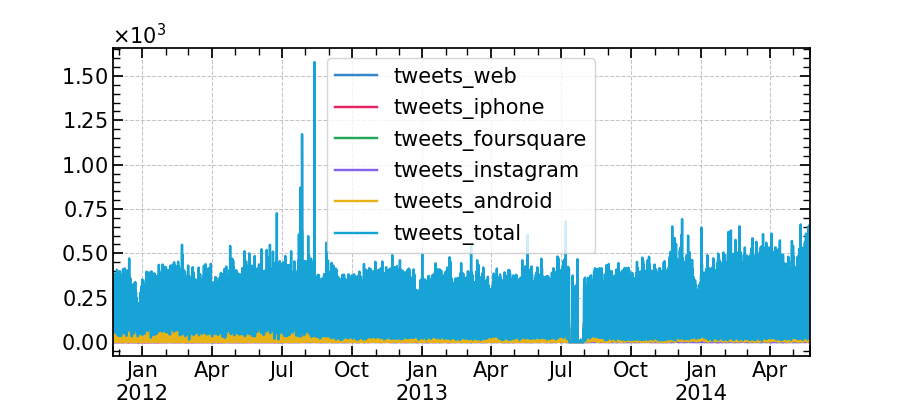

In [10]:
fig,  ax =  plt.subplots( figsize = (9,4))

final_df.plot(ax = ax)
